In [1]:
!pip install pytorch-ignite

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# 以下、PyTorch-Igniteからのインポート
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers


In [3]:
DATA_DIR='./data' # データ保存用のディレクトリ
IMAGE_SIZE = 32 # 入力画像1辺のサイズ
NUM_CLASSES = 10 # 分類先のクラス数
NUM_WORKERS = 2 # データローダーが使用するサブプロセスの数を指定
BATCH_SIZE = 32 # ミニバッチのサイズ
EPOCHS = 100 # 学習回数
LEARNING_RATE = 1e-3 # 学習率
WEIGHT_DECAY = 1e-1 # オプティマイザーの重み減衰率


In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)


device: cuda


In [5]:
train_transform = transforms.Compose([
    # 画像をランダムに左右反転
    transforms.RandomHorizontalFlip(),
    # 画像の各辺に4ピクセルのパディング（余白）を追加し、
    # ランダムな位置から32x32のサイズで切り抜く
    transforms.RandomCrop(32, padding=4),
    # PIL（Python Imaging Library）形式の画像をPyTorchのテンソルに変換
    transforms.PILToTensor(),
    # 画像のデータ型をtorch.floatに変換
    transforms.ConvertImageDtype(torch.float)
])


In [6]:
# CIFAR-10データセットのトレーニングデータを読み込み、データ拡張を適用
train_dset = datasets.CIFAR10(
    root=DATA_DIR, train=True, download=True, transform=train_transform)
# CIFAR-10データセットのテストデータを読み込み、
# 画像データをPIL形式からPyTorchのテンソルに変換する処理のみを行う
test_dset = datasets.CIFAR10(
    root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 170498071/170498071 [00:12<00:00, 13225853.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# トレーニング用のデータローダーを作成
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=BATCH_SIZE, # トレーニングデータとバッチサイズを設定
    shuffle=True, # 抽出時にシャッフルする
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True) # GPUを使用する場合、データを固定メモリにロードする
# テスト用のデータローダーを作成
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=BATCH_SIZE, # テストデータとバッチサイズを設定
    shuffle=False, # 抽出時にシャッフルしない
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True) # GPUを使用する場合、データを固定メモリにロードする


In [8]:
class Residual(nn.Module):
    """nn.Moduleクラスを継承した残差接続を行うレイヤー(層)を定義

    Attributes:
        residual:
            受け取ったレイヤーをnn.Sequentialで連結したシーケンシャルモデル
        gamma:
            学習可能なパラメーター
    """
    def __init__(self, *layers):
        """
        Args:
            *layers(可変長引数): 残差ブロック内で使用されるレイヤー（層）のリストを受け取る
        """
        super().__init__()
        #  受け取ったレイヤーをnn.Sequentialで連結する
        self.residual = nn.Sequential(*layers)
        # 学習可能な初期値ゼロのパラメータを1個作成
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """順伝搬処理を行う

        xをresidualレイヤーに入力し、その出力にスケーリング係数gammaを
        掛けた結果を元の入力xに加算して返す。これにより、残差接続が実現される

        Args:
            x: 入力するテンソル
        """
        return x + self.gamma * self.residual(x)


In [9]:
class GlobalAvgPool(nn.Module):
    """グローバル平均プーリングのレイヤー(層)を定義
    """
    def forward(self, x):
        """順伝搬処理を行う

        入力テンソルxの末尾から2番目の次元（パッチ数）について、
        パッチごとのチャンネル次元の平均を計算して返す

        Args:
        x: 入力するテンソル
        """
        return x.mean(dim=-2)


In [10]:
class ToPatches(nn.Module):
    """1枚の画像を小さなパッチに分割する

    Attributes:
        patch_size: パッチ1辺のサイズ(2)
        proj: パッチデータを線形変換する全結合層
        norm: 線形変換後に適用する正規化層
    """
    def __init__(self, in_channels, dim, patch_size):
        """
        Args:
            in_channels(int): 入力画像のチャンネル数(in_channels=3)
            dim(int): 線形変換後のパッチのサイズ
                      dims=[128, 128, 256]から取得した第1要素の128
            patch_size(int): パッチ1辺のサイズ(patch_size=2)
        """
        super().__init__()
        self.patch_size = patch_size # パッチ1辺のサイズ(2)
        # チャンネル数にパッチ1辺のサイズの平方を掛けてパッチ1個のサイズを計算
        # 3×2×2 = 12
        patch_dim = in_channels * patch_size**2
        # 入力のサイズをパッチのサイズ(12)
        # ユニット数をdimのサイズ(128)とした全結合層を定義
        self.proj = nn.Linear(patch_dim, dim)
        # 正規化層を定義
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        """パッチに分割する一連の順伝搬処理
        Args:
            x: 画像データ(bs, 3, 32, 32)
        """
        # 入力テンソルの形状:(bs, 3, 32, 32)
        # 出力テンソルの形状: (bs, 256[パッチ数], 12[パッチのサイズ])
        #
        # F.unfold()の引数で、カーネルサイズを12(パッチサイズ(2×2))、
        # ストライドのサイズを12(パッチサイズ(2×2))に指定
        # 画像1枚(1, 3, 32, 32)をパッチに分割して次の形状にする
        # (1,
        #  12[チャネル数3×4(パッチ1個の要素数)],
        #  256[16(高さ方向のパッチ数)×16(幅方向のパッチ数)])
        #
        # movedim(1, -1)においてパッチの次元を最後に移動すると(1, 256, 12)
        x = F.unfold(
            x, kernel_size=self.patch_size, stride=self.patch_size).movedim(1, -1)
        # パッチのサイズ(12)をdimのサイズ(128)に線形変換
        # 入力テンソルの形状: (bs, 256, 12)
        # 出力テンソルの形状: (bs, 256, 128)
        x = self.proj(x)
        # 正規化を行う
        x = self.norm(x)

        return x


In [11]:
class AddPositionEmbedding(nn.Module):
    """各パッチに位置情報を追加して特徴マップを生成する

    Attributes:
        pos_embedding: 位置情報としての学習可能なパラメーター
    """
    def __init__(self, dim, num_patches):
        """
        Args:
            dim(int):
               線形変換後のパッチのサイズ
               dims=[128, 128, 256]から取得した第1要素の128
            num_patches(int):
                特徴マップ1枚のパッチ数
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                行パッチ数(16) * 列パッチ数(16) = 256(パッチの数)
        """
        super().__init__()
        # (256, 128)の形状の学習可能なパラメーターを作成し、位置情報とする
        self.pos_embedding = nn.Parameter(torch.Tensor(num_patches, dim))

    def forward(self, x):
        """
        Args:
            x: パッチ分割後のデータ(bs, 256, 128)
        """
        # パッチ分割後の画像1枚当たり(256, 128)に位置情報(256, 128)を加算
        return x + self.pos_embedding


In [12]:
class ToEmbedding(nn.Sequential):
    """レイヤーを順次実行するSequentialのサブクラス

    パッチ分割、位置情報の埋め込みを実行して特徴マップを生成
    """
    def __init__(self, in_channels, dim, patch_size, num_patches, p_drop=0.):
        """
        Args:
            in_channels(int): 入力画像のチャンネル数(in_channels=3)
            dim(int): 線形変換後のパッチのサイズ
                      dims=[128, 128, 256]から取得した第1要素の128
            patch_size(int): パッチ1辺のサイズ(patch_size=2)
            num_patches(int):
                特徴マップ1枚のパッチ数
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                行パッチ数(16) * 列パッチ数(16) = 256(パッチの数)
            p_drop: ドロップアウト率(p_drop=0.)
        """
        super().__init__(
            # ToPatchesでパッチ分割
            ToPatches(in_channels, dim, patch_size),
            # AddPositionEmbeddingで位置情報を埋め込む
            AddPositionEmbedding(dim, num_patches),
            # ドロップアウト
            nn.Dropout(p_drop)
        )


In [13]:
class ShiftedWindowAttention(nn.Module):
    """nn.Moduleを継承したカスタムレイヤー

    Swin Transformerにおける以下の機構を実装する
    ・Window-based Multi-Head Self-Attention (W-MSA)
    ・Shifted Window-based Multi-Head Self-Attention (SW-MSA)

    Attributes:
        heads: ヘッドの数
        head_dim: ヘッドのサイズ
        scale: スケーリングファクター
        shape: 特徴マップの256個のパッチを正方行列にしたときの形状(16, 16)
        window_size: ウィンドウ1辺のサイズ
        shift_size: ウィンドウのシフト量
        pos_enc: 位置情報のための学習可能なパラメーター
    """
    def __init__(self, dim, head_dim, shape, window_size, shift_size=0):
        """
        Args:
            dim(int): 特徴マップにおけるパッチのサイズ
                      dims=[128, 128, 256]から取得した第1要素の128
            head_dim(int): ヘッドの次元数(head_dim=32)
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)

            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
            shift_size(int): ウィンドウのシフト量(shift_size=0)
        """
        super().__init__()
        # パッチのサイズdimをヘッドのサイズhead_dimで割ってヘッドの数を取得
        self.heads = dim // head_dim
        # ヘッドのサイズをself.head_dimに格納
        self.head_dim = head_dim
        # ヘッドのサイズhead_dimの平方根の逆数を計算し、
        # スケーリングファクターを求める(self.scale=0.17677...)
        self.scale = head_dim**-0.5

        self.shape = shape # 256個のパッチを正方行列にしたときの形状(16, 16)
        self.window_size = window_size # ウィンドウ1辺のサイズを設定
        self.shift_size = shift_size # シフトサイズを設定

        # クエリ、キー、バリューを生成するための全結合層
        # 入力次元数: パッチサイズdim(128,)
        # ユニット数: パッチサイズdim * 3(384,)
        self.to_qkv = nn.Linear(dim, dim * 3)

        # 各ヘッドの出力を統合するための全結合層
        # 入力次元数: パッチサイズdim(128,)
        # ユニット数: パッチサイズdim(128,)
        self.unifyheads = nn.Linear(dim, dim)

        # 相対位置エンコーディングのための学習可能なパラメーターを作成
        # 作成されるパラメーターテンソルの形状:
        # (ヘッド数, (2 * window_size - 1)**2)
        self.pos_enc = nn.Parameter(
            torch.Tensor(self.heads, (2 * window_size - 1)**2))

        # nn.Module.register_buffer()を使用して、
        # 相対位置インデックスが格納された1階テンソルをバッファに登録する
        # テンソルの形状: (window_size**4,)
        self.register_buffer(
            "relative_indices", # バッファ名
            self.get_indices(window_size))

        # シフトサイズが0より大きい場合にマスクを適用
        if shift_size > 0:
            # self.generate_mask()でマスクを生成し、バッファとして登録
            # マスクは5階テンソル:
            # (1, ウィンドウの数, 1, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
            self.register_buffer(
                "mask", self.generate_mask(shape, window_size, shift_size))

    def forward(self, x):
        """順伝搬処理

        Args:
            x: 特徴マップ(bs, パッチの数, パッチサイズ)
        """
        # シフト量とウィンドウ1辺のサイズをローカル変数に格納
        shift_size, window_size = self.shift_size, self.window_size

        # 特徴マップの各特徴をウィンドウに分割し、必要に応じてシフトする
        # 入力テンソルの形状: (bs, 256, 128)
        # 分割処理後の形状:
        # (bs * ウィンドウの数,
        #  ウィンドウ内パッチ数(window_size**2), パッチサイズ)
        x = self.to_windows(x,
                            self.shape, # shape=(16, 16)
                            window_size,
                            shift_size)

        # 全結合層を使ってクエリ、キー、バリューのテンソルを生成
        # self.to_qkv(x)におけるテンソルの形状:
        # (bs * ウィンドウの数, ウィンドウ内パッチ数, パッチサイズ * 3)
        # の最後の次元をq、k、vの3次元、ヘッド数の次元、ヘッドサイズの次元に分割
        # (bs * ウィンドウの数,
        #  ウィンドウ内パッチ数, 3(q,k,v)、ヘッド数、ヘッドサイズ)
        # さらにヘッド数の次元とウィンドウ内パッチ数の次元を入れ替える
        # 処理後: (bs * ウィンドウの数,
        #          ヘッド数, 3[q,k,v], ウィンドウ内パッチ数, ヘッドサイズ)
        qkv = self.to_qkv(x).unflatten(
            -1, (3, self.heads, self.head_dim)).transpose(-2, 1)

        # qkvの第3次元（3[q,k,v]）に沿って3つのテンソルに分割
        # queries, keys, valuesのテンソルの形状:
        # (bs * ウィンドウの数, ヘッド数, ウィンドウ内パッチ数, ヘッドのサイズ)
        queries, keys, values = qkv.unbind(dim=2)

        # クエリとキーの行列積を計算して、各クエリに対する各キーの類似度を求める
        # att(類似度スコア)の形状:
        # (bs * ウィンドウ数, ヘッド数, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        att = queries @ keys.transpose(-2, -1)

        # 類似度スコアにスケーリングファクターを適用し、
        # get_rel_pos_enc()で得られた相対位置エンコーディング
        # 形状: (ヘッド数, window_size**2, window_size**2)を加算
        # スケーリングファクター、相対位置エンコーディング適用後attの形状:
        # (bs * ウィンドウ数, ヘッド数, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        att = att * self.scale + self.get_rel_pos_enc(window_size)

        # shift_sizeが0より大きい場合に、アテンションスコアattにマスキング処理を適用
        # マスキング処理後のatt(Attentionスコア)の形状;
        # (bs * ウィンドウ数, ヘッド数, window_size**2, window_size**2)
        if shift_size > 0:
            att = self.mask_attention(att)

        # アテンションスコアatt にソフトマックスを適用
        # dim=-1 は、最後の次元に沿ってソフトマックスを適用することを意味
        # ソフトマックスを適用後att(Attentionスコア)の形状:
        # (bs * ウィンドウ数, ヘッド数, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        att = F.softmax(att, dim=-1)

        # ソフトマックス適用後のアテンションスコアattとvalues の行列積を計算
        # これにより、各クエリに対する重み付けされた値の合計が得られる
        # att:
        # (bs * ウィンドウ数, ヘッド数, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        # values:
        # (bs * ウィンドウの数, ヘッド数, ウィンドウ内パッチ数, ヘッドのサイズ)
        # 行列積の結果:
        # (bs * ウィンドウ数, ヘッド数, ウィンドウ内パッチ数, ヘッドのサイズ)
        x = att @ values

        # ヘッドの数とウィンドウ内のパッチの数の次元をを入れ替えて次の形状にする
        # (bs * ウィンドウ数, ウィンドウ内のパッチ数, ヘッド数, ヘッドのサイズ)
        # メモリ上で連続した領域を持つように変換後、
        # 最後の2つの次元(ヘッド数とヘッドのサイズ)をフラット化して結合
        # 処理後: (bs * ウィンドウ数, ウィンドウ内のパッチ数, パッチのサイズ)
        x = x.transpose(1, 2).contiguous().flatten(-2, -1)

        # パッチサイズと同じユニット数の全結合層に入力し、各ヘッドの出力を統合
        # 出力の形状:
        # (bs * ウィンドウ数, ウィンドウ内のパッチ数, パッチのサイズ)
        x = self.unifyheads(x)

        # ウィンドウに分割した状態とウィンドウのシフト処理を解除して、元の形状
        # (bs, パッチの数, パッチのサイズ)にする
        x = self.from_windows(x, self.shape, window_size, shift_size)

        return x

    def to_windows(self, x, shape, window_size, shift_size):
        """ 特徴マップを必要に応じてシフト処理を行い、
            split_windows()メソッドを実行してウィンドウに分割する

        Args:
            x: 特徴マップ(bs, パッチ数, パッチサイズ)
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
            shift_size(int): ウィンドウのシフト量
        Returns:
            x: 特徴マップをwindow_sizeに従って分割処理したテンソル
               (bs * ウィンドウ数, パッチ数(window_size**2), パッチサイズ)
        """
        # 特徴マップ(bs, パッチ数, パッチサイズ)のパッチ数の次元を
        # 正方行列にしたときの形状shape=(16, 16)に展開
        # 処理後のxの形状:
        #   (bs, パッチ数(行), パッチ数(列), パッチサイズ)
        x = x.unflatten(1, shape)

        # シフトサイズが0より大きい場合にテンソルxをシフトする
        if shift_size > 0:
            x = x.roll((-shift_size, -shift_size), dims=(1, 2))

        # split_windows()を実行し、window_sizeに基づいてウィンドウに分割
        # 処理後のxの形状:
        # (bs * ウィンドウ数, ウィンドウ内パッチ数(window_size**2), パッチサイズ)
        x = self.split_windows(x, window_size)
        return x

    def get_rel_pos_enc(self, window_size):
        """相対位置エンコーディングをself.pos_encから収集

        Args:
            window_size: ウィンドウ1辺のサイズ
        Returns:
            相対位置エンコーディングを格納した3階テンソル
            形状:(ヘッド数, window_size**2, window_size**2)
        """
        # ウィンドウ内の各パッチ間の相対位置を格納した
        # relative_indices: ((window_size**2) * (window_size**2),)を
        # ヘッドの数に拡張 -> (ヘッド数, (window_size**2) * (window_size**2))
        indices = self.relative_indices.expand(self.heads, -1)
        # 学習可能なパラメーターself.pos_enc(ヘッド数, (2*window_size-1)**2)から
        # indicesの各インデックスに対応する値(相対位置エンコーディング)を収集
        # rel_pos_encの形状: (ヘッド数, (window_size**2) * (window_size**2))
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        # 相対位置エンコーディングrel_pos_encの第2次元
        # (window_size**2) * (window_size**2)を(window_size**2, window_size**2)
        # の形状に変更、rel_pos_encは3階テンソルになる
        # (ヘッド数, window_size**2, window_size**2)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (window_size**2, window_size**2))

        return rel_pos_enc

    def mask_attention(self, att):
        """アテンションスコアのテンソルにマスクを適用

        ウィンドウの境界をまたぐ位置にあるアテンションスコアに
        負の無限大'-inf'が埋め込まれる

        Args:
            att: スケーリングファクター、相対位置エンコーディング
                 適用後のアテンションスコア:
                 (bs * ウィンドウ数, ヘッド数, window_size**2, window_size**2)
        Returns:
            マスク適用後のアテンションスコア
            (bs * ウィンドウ数, ヘッド数, window_size**2, window_size**2)
        """
        # マスクのウィンドウ数を取得、ブール値のself.maskの形状は
        # (1, ウィンドウの数, 1, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        # 第2次元のサイズ(ウィンドウの数)を取得
        num_win = self.mask.size(1)

        # att.size(0) // num_winで次元サイズをウィンドウ数で割ってbsを取得
        # attの第1次元(bs * ウィンドウ数)をbsとウィンドウ数で分割する
        # att: (bs, ウィンドウ数, ヘッド数, window_size**2, window_size**2)
        att = att.unflatten(0, (att.size(0) // num_win, num_win))

        # マスク(1, ウィンドウ数, 1,ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        # を適用して、マスクされた位置に負の無限大を埋め込む
        # attの形状: (bs, num_win, ヘッド数, window_size**2, window_size**2)
        att = att.masked_fill(self.mask, float('-inf'))

        # attの第1次元と第2次元をフラット化して、元の4階テンソルの形状に戻す
        # 処理後: (bs * ウィンドウ数, ヘッド数, window_size**2, window_size**2)
        att = att.flatten(0, 1)
        return att

    def from_windows(self, x, shape, window_size, shift_size):
        """ ウィンドウに分割した状態を解除して、元の特徴マップの形状に戻す

        Args:
            x: ウィンドウに分割された特徴マップ
                (bs * ウィンドウ数, ウィンドウ内パッチ数, パッチサイズ)
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
            shift_size(int): ウィンドウのシフト量

        Returns:
            x: 元の特徴マップの形状 (bs, パッチ数, パッチサイズ)
        """
        # merge_windows()を使用してウィンドウを結合し、分割を解除
        x = self.merge_windows(x, shape, window_size)
        # シフトサイズが0より大きい場合、以前に行われたシフト処理を元に戻す
        if shift_size > 0:
            x = x.roll((shift_size, shift_size), dims=(1, 2))
        # 結合後の形状 (bs, 行パッチ数, 列パッチ数, パッチサイズ) の
        # 行パッチ数と列パッチ数の次元をフラット化して
        # (bs, パッチ数, パッチサイズ) の形状にする
        x = x.flatten(1, 2)
        return x

    # 静的メソッド
    @staticmethod
    def get_indices(window_size):
        """相対位置インデックスを計算

        Args:
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
        Returns:
            ウィンドウ内のすべてのパッチを組み合わせた相対位置インデックス
            (window_size(行), window_size(列), window_size(行), window_size(列))を
            (window_size**4,)にフラット化したテンソル
        """
        # 0からwindow_size - 1までの1階テンソル[0, 1, 2, 3]を作成
        x = torch.arange(window_size, dtype=torch.long)
        # x の要素を使って4次元のグリッドを生成、生成される各テンソルの形状:
        # (window_size(行), window_size(列), window_size(行), window_size(列))
        y1, x1, y2, x2 = torch.meshgrid(x, x, x, x, indexing='ij')
        # 相対位置を示すインデックスを求める　indicesの形状:
        # (window_size(行), window_size(列), window_size(行), window_size(列))
        indices = ((y1 - y2 + window_size - 1) * (2 * window_size - 1) +
                   (x1 - x2 + window_size - 1))
        # インデックスを1階テンソルにフラット化して
        # (window_size**4, )の1階テンソルにする
        indices = indices.flatten()
        return indices

    @staticmethod
    def generate_mask(shape, window_size, shift_size):
        """ マスクを生成

            シフトによってウィンドウが重なる場合、
            ウィンドウの境界をまたぐ部分を検出するためのマスクを生成
            ウィンドウの境界をまたぐアテンションスコアを
            無視するために使用される

        Args:
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
            shift_size(int): ウィンドウのシフト量
        Returns:
            異なる領域間のアテンションスコアを無視するために使用される
            ブール値のマスクテンソル:
            (1, ウィンドウの数, 1, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        """
        # shapeの値(行パッチ数, 列パッチ数)の要素を展開して
        # (1, 行パッチ数, 列パッチ数, 1)の形状のテンソルを作成
        # 第1次元の1はバッチデータに対応するための次元
        # 全ての要素をゼロで初期化
        # region_maskの形状: (1, 行パッチ数, 列パッチ数, 1)
        region_mask = torch.zeros(1, *shape, 1)
        # ウィンドウのシフトに基づいて3つの異なる範囲を定義
        # これらのスライスはウィンドウの境界を決定する
        slices = [
            slice(0, -window_size), # 最初の領域
            slice(-window_size, -shift_size), # 中間の領域
            slice(-shift_size, None) # 最後の領域
        ]

        # 各領域に割り当てる番号を保持するカウンター変数を0で初期化
        region_num = 0
        # 2重ループを使って3つのスライスを組み合わせ、
        # 各領域に対して番号を割り当てる
        # region_maskの形状(1, 行パッチ数, 列パッチ数, 1])
        for i in slices:
            for j in slices:
                region_mask[:, i, j, :] = region_num
                region_num += 1

        # region_mask(1, 行パッチ数, 列パッチ数, 1)を split_windows()で
        # 複数のウィンドウに分割して次の形状のテンソルを取得
        # (ウィンドウの数, ウィンドウ内パッチ数, パッチサイズ)
        # 第3次元のパッチサイズの要素数は1なので、この次元を削除
        # 処理後; (ウィンドウの数, ウィンドウ内パッチ数(window_size**2)
        mask_windows = ShiftedWindowAttention.split_windows(
            region_mask, window_size).squeeze(-1)

        # ウィンドウ内の各パッチが他のすべてのパッチに対して持つ相対位置関係を計算
        # 異なる領域に属するパッチペアを識別するためのデータを作成
        # mask_windows.unsqueeze(1): (ウィンドウ数, 1, ウィンドウ内パッチ数)
        # mask_windows.unsqueeze(2): (ウィンドウ数, ウィンドウ内パッチ数, 1)
        #
        # 計算の結果、すべてのウィンドウ内の各パッチとその他のすべてのパッチとの
        # 組み合わせによる相対的な位置関係の差分が得られる
        # 形状: (ウィンドウ数, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        diff_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)

        # 差がゼロではない領域（異なる領域に属する部分）を検出「異なる領域」とは、
        # シフトによってウィンドウが重なる場合に発生する境界をまたぐ部分
        # 結果、mask はブール値のマスクテンソルとなり、
        # 異なる領域に属する部分がTrueになる
        # maskの形状:(ウィンドウ数, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        mask = diff_mask != 0

        # maskの第2次元の位置に新しい次元を挿入(ヘッドのため)
        # さらに第1次元の位置に新しい次元を挿入(バッチデータのため)
        # (1, ウィンドウの数, 1, ウィンドウ内パッチ数, ウィンドウ内パッチ数)
        mask = mask.unsqueeze(1).unsqueeze(0)
        return mask

    @staticmethod
    def split_windows(x, window_size):
        """window_sizeに基づいてパッチテンソルxをウィンドウに分割

        Args:
            x: パッチテンソル(bs, パッチ数(行), パッチ数(列), パッチサイズ(データ数))
            window_size: ウィンドウ1辺のサイズ
        Returns:
            x: 入力テンソルxをウィンドウに分割後のテンソル
               (bs * ウィンドウ数, ウィンドウ内パッチ数(window_size**2), パッチサイズ)
        """
        # テンソルxの第2次元(パッチ数(行))、第3次元(パッチ数(列))を
        # window_sizeで割って、行方向のウィンドウの数n_hと
        # 列方向のウィンドウの数n_wを求める
        n_h, n_w = x.size(1) // window_size, x.size(2) // window_size

        # テンソルxの第2次元(パッチ数(行))、第3次元(パッチ数(列))をそれぞれ
        # ウィンドウの数とウィンドウサイズにアンフラット化(展開)することで、
        # パッチ行列を複数ウィンドウに分割する
        # 分割後の6階テンソル:
        #   (bs, ウィンドウ数(行), 行のwindow_size,
        #        ウィンドウ数(列), 列のwindow_size, パッチサイズ)
        x = x.unflatten(1, (n_h, window_size)).unflatten(-2, (n_w, window_size))

        # 第3次元(行のwindow_size)と第4次元(ウィンドウ数(列))を入れ替えて
        # 第1次元、第2次元、第3次元までをフラット化
        # 処理後の形状:
        # (bs * ウィンドウの数(行*列), 行のwindow_size, 列のwindow_size, パッチサイズ)
        x = x.transpose(2, 3).flatten(0, 2)

        # 第2次元(行のwindow_size)と第3次元(列のwindow_size)をフラット化
        # 各ウィンドウのデータを連結、処理後の形状:
        # (bs * ウィンドウの数, ウィンドウ内パッチ数(window_size**2), パッチサイズ)
        x = x.flatten(-3, -2)
        return x

    @staticmethod
    def merge_windows(x, shape, window_size):
        """ ウィンドウに分割されたテンソルを元の形状に戻す

        Args:
            x: ウィンドウに分割された状態の特徴マップ
            (bs * ウィンドウ数, ウィンドウ内パッチ数, パッチサイズ)
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)

        Returns:
            x: 元の特徴マップの形状 (bs, パッチ数(行), パッチ数(列), パッチサイズ)
        """
        # 行方向と列方向のウィンドウの数を計算
        n_h, n_w = shape[0] // window_size, shape[1] // window_size
        # バッチサイズを計算
        bs = x.size(0) // (n_h * n_w)
        # テンソルxの第2次元(ウィンドウ内パッチ数)をwindow_sizeに従って行と列に分割
        # (bs * ウィンドウ数, パッチ数(行), パッチ数(列),パッチサイズ)
        x = x.unflatten(1, (window_size, window_size))
        # xの第1次元をバッチサイズ、行方向ウィンドウ数、列方向ウィンドウ数に分離、
        # 第3次元(列方向ウィンドウ数)と第4次元(ウィンドウ内パッチ数(行))を入れ替え
        # (bs, ウィンドウ数(行), パッチ数(行),
        #      ウィンドウ数(列),パッチ数(列), パッチサイズ)
        x = x.unflatten(0, (bs, n_h, n_w)).transpose(2, 3)
        # 第2次元(行方向ウィンドウ数)、第3次元(パッチ数(行))をフラット化
        # さらに第3次元(列方向ウィンドウ数)、第4次元(パッチ数(列))をフラット化
        # (bs, パッチ数(行), パッチ数(列), パッチサイズ)
        x = x.flatten(1, 2).flatten(-3, -2)
        return x


In [14]:
class FeedForward(nn.Sequential):
    """ nn.Sequentialクラスを継承したサブクラス

        隠れ層: 線形変換とGELU活性化関数を適用
        出力層: 線形変換を適用後、出力
    """
    def __init__(self, dim, mult=4):
        """
        Args:
            dim(int): 線形変換後のパッチのサイズ
                      dims=[128, 128, 256]から取得した第1要素の128
            mult(int): 隠れ層の次元を決定する乗数（mult=4）
        """
        # 入力の次元dimにmultを掛けて、隠れ層の次元数hidden_dimを計算
        hidden_dim = dim * mult
        super().__init__(
            # 隠れ層: 線形変換、入力次元はdim、ユニット数はhidden_dim
            nn.Linear(dim, hidden_dim),
            # GELU活性化関数を適用
            nn.GELU(),
            # 出力層: 線形変換、入力次元はhidden_dim、ユニット数はdim
            nn.Linear(hidden_dim, dim)
        )


In [15]:
class TransformerBlock(nn.Sequential):
    """ 残差接続を行うレイヤー(残差ブロック)を2層構築する

    """
    def __init__(self,
                 dim, head_dim, shape, window_size, shift_size=0, p_drop=0.):
        """
        Args:
            dim(int): 線形変換後のパッチのサイズ
                      dims=[128, 128, 256]から取得した第1要素の128
            head_dim(int): ヘッドの次元数(head_dim=32)
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
            shift_size(int): ウィンドウのシフト量(shift_size=0)
            p_drop(float): ドロップアウトの確率
        """
        super().__init__(
            # 第1の残差ブロックを作成
            Residual(
                # 標準化(正規化)を適用
                nn.LayerNorm(dim),
                # W-MSA、SW-MSAを実装したShiftedWindowAttentionを適用
                ShiftedWindowAttention(
                    dim, head_dim, shape, window_size, shift_size
                ),
                # ドロップアウトを適用
                nn.Dropout(p_drop)
            ),
            # 第2の残差ブロックを作成
            Residual(
                # 標準化(正規化)を適用
                nn.LayerNorm(dim),
                # フィードフォワードネットワークを適用
                FeedForward(dim),
                # ドロップアウトを適用
                nn.Dropout(p_drop)
            )
        )


In [16]:
class PatchMerging(nn.Module):
    """ nn.Moduleを継承したカスタムレイヤー

    Patch Mergingの処理として、
    パッチ次元(パッチ数)を1/2に集約し、パッチサイズを調整する

    Attributes:
        shape: 特徴マップの形状（行数, 列数）
        norm: 標準化(正規化)を行うレイヤー
        reduction: チャンネル次元(パッチデータ)を増やすための全結合層
    """
    def __init__(self, in_dim, out_dim, shape):
        """
        Args:
            in_dim: 入力次元数（パッチのサイズ）
            out_dim: 出力層の次元(ユニット数)
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)
        """
        super().__init__()
        self.shape = shape
        # 標準化の処理　入力次元数はin_dimの4倍
        # kernel_size * kernel_size=4
        self.norm = nn.LayerNorm(4 * in_dim)
        # チャンネル次元を増やすための全結合層
        # 4 * in_dimからout_dimへの線形変換を行う
        self.reduction = nn.Linear(4 * in_dim, out_dim, bias=False)

    def forward(self, x):
        """
        Args:
            x: 入力テンソル。形状は (bs, パッチ数, パッチサイズ)
        """
        # テンソルxの第1次元のパッチ数を(パッチ数(行), パッチ数(列))に展開し、
        # 末尾のチャンネル(パッチサイズ)次元を先頭に移動
        # 入力: (bs, パッチ数, パッチサイズ)
        # 出力: (bs, パッチサイズ, パッチ数(行), パッチ数(列))
        x = x.unflatten(1, self.shape).movedim(-1, 1)

        # 2x2のカーネルを使用してパッチ4個を結合し、
        # ストライド2でパッチの数を1/2にする
        # 入力: (bs, パッチサイズ, パッチ数(行), パッチ数(列))
        # パッチ集約後:
        # (bs, パッチサイズ * kernel_size * kernel_size, 新しいパッチの数)
        #
        # 第3次元と第2次元を入れ替える
        # (bs, 新しいパッチの数, パッチサイズ * kernel_size * kernel_size)
        x = F.unfold(x, kernel_size=2, stride=2).movedim(1, -1)

        # 標準化(正規化)を適用
        x = self.norm(x)
        # 線形変換を適用してチャンネルの次元数(パッチサイズ)をout_dimの数にする
        # x: (bs, パッチ数, 新しいパッチサイズ)
        x = self.reduction(x)

        return x


In [17]:
class Stage(nn.Sequential):
    """ Swin Transformerのステージ(ブロック)を構築する

        ステージには必要に応じてPatchMerging層を配置し、
        続いて複数のTransformerBlockを配置
        偶数番目のTransformerBlockではシフト量を0に、
        機数番目のTransformerBlockではシフト量をwindow_sizeの半分にして
        W-MSAとSW-MSAを交互に適用し、パッチ間の対応関係を捉える
    """
    def __init__(self, num_blocks, in_dim, out_dim,
                 head_dim, shape, window_size, p_drop=0.):
        """
        Args:
            num_blocks_list(list):
               各ステージに含まれるTransformerBlockの数
               (num_blocks_list=[4, 4])
            in_dim: 入力の次元数
            out_dim: 出力層の次元(ユニット数)
            head_dim(int): ヘッドの次元数(head_dim=32)
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
            p_drop(float): ドロップアウトの確率(p_drop=0.)
        """
        # in_dimとout_dimが異なる場合、特徴マップの次元を変換するためにPatchMergingを追加
        if out_dim != in_dim:
            # shapeを半分に縮小するためのPatchMergingレイヤーを
            # インスタンス化してリストlayersに格納
            layers = [PatchMerging(in_dim, out_dim, shape)]
            # 特徴マップの形状shapeの行数と列数を半分に縮小
            shape = (shape[0] // 2, shape[1] // 2)
        else:
            # in_dimとout_dimの次元数が同じであれば空のリストlayersを返す
            layers = []

        # ウィンドウサイズの半分をシフトサイズとして設定
        shift_size = window_size // 2
        # num_blocksの数だけTransformerBlockを追加
        # 偶数番目のブロックにはシフトを適用しない
        # 奇数番目のブロックにはシフトを適用する
        layers += [
            TransformerBlock(
                out_dim, # 出力次元数
                head_dim, # ヘッドの次元数
                shape, # 特徴マップの形状
                window_size, # ウィンドウ1辺のサイズ
                # シフトサイズ：
                # 偶数番目のブロックではシフト量を0、
                # 奇数番目のブロックではシフト量をwindow_sizeの半分に設定
                0 if (num % 2 == 0) else shift_size,
                p_drop # ドロップアウト率
            )
            # num_blocksの数だけループしてTransformerBlockを追加
            for num in range(num_blocks)
        ]
        # 親クラスnn.Sequentialの初期化メソッドを呼び出して
        # layersリスト内の全てのレイヤーを構築する
        super().__init__(*layers)


In [18]:
class StageStack(nn.Sequential):
    """Swin Transformerモデルのステージをスタックするクラス

    複数のステージ(Stage)を積み重ねてネットワークを構築する
    """
    def __init__(self, num_blocks_list, dims,
                 head_dim, shape, window_size, p_drop=0.):
        """
        Args:
            num_blocks_list(list):
               各ステージに含まれるTransformerBlockの数
               (num_blocks_list=[4, 4])
            dims(list):
               ステージの入力次元数と出力次元数のリスト
               (dims=[128(入力次元数),
                      128(第1Stage出力次元数),
                      256(第2Stage出力時減数)])
            head_dim(int): ヘッドの次元数(head_dim=32)
            shape(tuple):
                特徴マップの256個のパッチを正方行列にしたときの形状
                画像1辺のサイズをパッチ1辺のサイズで割って行、列のサイズshapeを取得
                shape = (image_size // patch_size, image_size // patch_size)
                shape = (16, 16)
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
            p_drop(float): ドロップアウトの確率(p_drop=0.)
        """
        # リストlayersを初期化
        layers = []
        # 最初のステージの入力次元数をdimsリストの先頭要素から取得
        in_dim = dims[0]

        # zip()を使って、num_blocks_listとdimsから
        # 各StageのTransformerBlockの数とdimsの第2要素以降
        # (各Stageの出力次元数)を順次、取得
        for num, out_dim in zip(num_blocks_list, dims[1:]):
            # 各ステージのTransformerBlockの数num、入力次元数in_dim、
            # 出力次元数out_dimを用いてStageを作成し、layersリストに追加
            layers.append(
                Stage(num, # Stage1:4, Stage2:4
                      in_dim, # Stage1:128, Stage2:128
                      out_dim, # Stage1:128, Stage2:256
                      head_dim, shape, window_size, p_drop))
            # ステージの入力次元数と出力次元数が異なる場合、
            # 次のステージのために特徴マップの形状と入力時減数を更新しておく
            if in_dim != out_dim:
                # 特徴マップの形状（行数と列数）を半分に縮小
                shape = (shape[0] // 2, shape[1] // 2)
                # 次のステージの入力次元数を更新
                in_dim = out_dim

        # 親クラスnn.Sequentialの初期化メソッドを呼び出して
        # layersリスト内の全てのレイヤーを構築
        super().__init__(*layers)


In [19]:
class Head(nn.Sequential):
    """ Swin Transformerモデルの出力層を定義

    入力特徴量を正規化し、非線形変換を適用、グローバル平均プーリングを行い、
    ドロップアウトを適用してから最終的に線形層を通じてクラス分類を行う
    """
    def __init__(self, dim, classes, p_drop=0.):
        """
        Args:
            dim: 入力特徴量の次元数
                 dims=[128, 128, 256]における第1要素の128
            classes(int): 分類先のクラス数(NUM_CLASSES = 10)
            p_drop(float): ドロップアウト率(p_drop=0.)
        """
        # 親クラス(nn.Sequential)のコンストラクターを呼び出し、
        # 以下のレイヤーを順番に追加する
        super().__init__(
            nn.LayerNorm(dim), # 正規化を行うレイヤー
            nn.GELU(), # 活性化関数GELUを適用
            GlobalAvgPool(), # グローバル平均プーリング
            nn.Dropout(p_drop), # ドロップアウト
            nn.Linear(dim, classes) # 全結合層でクラス分類を実施
        )


In [20]:
class SwinTransformer(nn.Sequential):
    """Swin Transformerモデルを定義するクラス

    """
    def __init__(
            self, classes, image_size, num_blocks_list, dims, head_dim,
            patch_size, window_size, in_channels=3, emb_p_drop=0.,
            trans_p_drop=0., head_p_drop=0.
            ):
        """
        Args:
            classes(int): 分類先のクラス数(NUM_CLASSES = 10)
            image_size(int): 入力画像1辺のサイズ(IMAGE_SIZE = 32)

            num_blocks_list(list):
               各ステージに含まれるTransformerBlockの数
               (num_blocks_list=[4, 4])
            dims(list):
               各ステージの入力次元と出力次元のリスト
               (dims=[128, 128, 256])

            head_dim(int): ヘッドの次元数(head_dim=32)
            patch_size(int): パッチ1辺のサイズ(patch_size=2)
            window_size(int): ウィンドウ1辺のサイズ(window_size=4)
            in_channels(int): 入力チャンネル数(in_channels=3)

            emb_p_drop(float):
                Embedding層のドロップアウト率(emb_p_drop=0.)
            trans_p_drop(float):
                TransformerBlockのドロップアウト率(trans_p_drop=0.)
            head_p_drop(float):
                出力層のドロップアウト率(head_p_drop=0.3)
        """
        # 画像1辺のサイズをパッチサイズで割って、パッチ数を計算
        reduced_size = image_size // patch_size
        # パッチ分割後の特徴マップの形状を定義: (パッチ数(行), パッチ数(列))
        shape = (reduced_size, reduced_size)
        # 特徴マップ1個当たりのパッチ数を計算: パッチ数(行) * パッチ数(列)
        num_patches = shape[0] * shape[1]

        # nn.Sequentialクラスの初期化メソッドを呼び出して、各レイヤーを配置
        super().__init__(
            # ToEmbeddingを配置
            ToEmbedding(
                in_channels, # in_channels=3
                dims[0], # dims=[128, 128, 256]の第1要素128を取得
                patch_size, # patch_size=2
                num_patches, # パッチ数(行) * パッチ数(列
                emb_p_drop # emb_p_drop=0.
            ),
            # StageStackを配置
            StageStack(
                num_blocks_list, # num_blocks_list=[4, 4]
                dims, # dims=[128, 128, 256]
                head_dim, # head_dim=32
                shape, # (パッチ数(行), パッチ数(列))
                window_size, # window_size=4
                trans_p_drop # trans_p_drop=0.
            ),
             # Headブロックを配置
            Head(
                dims[-1], # dims=[128, 128, 256]から第3要素256を取得
                classes, # NUM_CLASSES = 10
                head_p_drop # head_p_drop=0.3
            )
        )
        # モデルパラメータの初期化を実行
        self.reset_parameters()

    def reset_parameters(self):
        """ モデルのパラメーターを初期化する
        """
        # self.modules() を用いてSwinTransformerのすべてのレイヤーを取得し、
        # それぞれのレイヤーに応じた初期化を行う
        for m in self.modules():
            # レイヤーの型名がnn.Linearの場合
            if isinstance(m, nn.Linear):
                # 重み: Kaiming正規分布(He)で初期化
                nn.init.kaiming_normal_(m.weight)
                # バイアス: ゼロで初期化
                if m.bias is not None: nn.init.zeros_(m.bias)
            # レイヤーの型名がnn.LayerNormの場合
            elif isinstance(m, nn.LayerNorm):
                # 重み: 1で初期化。Layer Normalizationでは、初期値が1が一般的
                nn.init.constant_(m.weight, 1.)
                # バイアス: ゼロで初期化
                nn.init.zeros_(m.bias)
            # レイヤーの型名がAddPositionEmbeddingの場合
            elif isinstance(m, AddPositionEmbedding):
                # 位置情報(絶対位置エンコーディング)を学習するパラメーター
                # pos_embedding:
                # 平均0.0、標準偏差0.02の正規分布からサンプリングした値で初期化
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            # レイヤーの型名がShiftedWindowAttentionの場合
            elif isinstance(m, ShiftedWindowAttention):
                # 位置エンコーディングを学習するパラメーターpos_enc:
                # 平均0.0、標準偏差0.02の正規分布からサンプリングした値で初期化
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            # レイヤーの型名がResidualの場合
            elif isinstance(m, Residual):
                # 学習可能なスケーリングファクターgammaをゼロで初期化
                nn.init.zeros_(m.gamma)

    def separate_parameters(self):
        """モデルのパラメータを重み減衰(Weight Decay)ありとなしで分ける

        オプティマイザー(最適化器)の学習過程において、
        重み減数を適用する、重み減衰を適用しないパラメーターを設定する

        Returns:
            parameters_decay(set); 重み減衰を適用するパラメーター名を格納
            parameters_no_decay(set): 重み減衰を適用しないパラメーター名を格納
        """
        # 重み減衰を適用するパラメーター名を格納する集合
        parameters_decay = set()
        # 重み減衰を適用しないパラメーター名を格納する集合
        parameters_no_decay = set()
        # 重み減衰を適用するレイヤーの型名
        modules_weight_decay = (nn.Linear, )
        # 重み減衰を適用しないレイヤーの型名
        modules_no_weight_decay = (nn.LayerNorm,)

        # モデル内の全てのネットワークモジュール(レイヤー)の名前と型名を順次抽出
        for m_name, m in self.named_modules():
            # 各レイヤーのパラメーター名とパラメーターテンソルを順次通出
            for param_name, param in m.named_parameters():
                # モジュール名とパラメーター名をピリオドで連結してフルネームを作成
                full_param_name = (
                    f"{m_name}.{param_name}" if m_name else param_name
                )
                # mに格納されているレイヤーの型名が
                # modules_no_weight_decayに含まれる場合
                # パラメーター名を重み減衰なし(parameters_no_decay)に追加
                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                # パラメーター名が "bias" で終わる場合
                # 重み減衰なし(parameters_no_decay)に追加
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                # レイヤーの型名がResidualで、パラメーター名が "bias"で終わる場合
                # パラメーター名を重み減衰なし(parameters_no_decay)に追加
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                # レイヤーの型名がAddPositionEmbeddingで、
                # パラメーター名が "pos_embedding"で終わる場合
                # パラメーター名を重み減衰なし(parameters_no_decay)に追加
                elif isinstance(m, AddPositionEmbedding) and \
                     param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                # レイヤーの型名がShiftedWindowAttentionで、
                # パラメーター名が "pos_enc"で終わる場合
                # パラメーター名を重み減衰なし(parameters_no_decay)に追加
                elif isinstance(m, ShiftedWindowAttention) and \
                     param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                # mに格納されているモジュールのインスタンス名が
                # modules_weight_decayに含まれる場合(nn.Linear)
                # パラメーター名を重み減衰あり(parameters_decay)に追加
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # parameters_decayとparameters_no_decayに
        # 同じパラメーター名が含まれていないことを確認
        assert len(parameters_decay & parameters_no_decay) == 0
        # parameters_decayとparameters_no_decayの要素の合計数が
        # モデルの全パラメータ数と一致することを確認
        assert len(parameters_decay) + len(parameters_no_decay) == \
               len(list(model.parameters()))

        return parameters_decay, parameters_no_decay


In [21]:
import torch
from torchsummary import summary

# モデルをインスタンス化
model = SwinTransformer(
    NUM_CLASSES,  # 分類先のクラス数
    IMAGE_SIZE,  # 入力画像1辺のサイズ
    num_blocks_list=[4, 4],  # 各Stageに含まれるTransformerBlockの数
    dims=[128, 128, 256],  # 各Stageの入力次元と出力次元のリスト
    head_dim=32,  # ヘッドの次元数
    patch_size=2,  # パッチ1辺のサイズ
    window_size=4,  # ウィンドウ1辺のサイズ
    emb_p_drop=0.,  # Embedding層のドロップアウト率
    trans_p_drop=0.,  # Transformer層のドロップアウト率
    head_p_drop=0.3  # 出力層のドロップアウト率
    )

# モデルをGPUに移動（GPUを使う場合）
model.to(DEVICE)
# モデルのサマリを表示
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 256, 128]           1,664
         LayerNorm-2             [-1, 256, 128]             256
         ToPatches-3             [-1, 256, 128]               0
AddPositionEmbedding-4             [-1, 256, 128]               0
           Dropout-5             [-1, 256, 128]               0
         LayerNorm-6             [-1, 256, 128]             256
            Linear-7              [-1, 16, 384]          49,536
            Linear-8              [-1, 16, 128]          16,512
ShiftedWindowAttention-9             [-1, 256, 128]               0
          Dropout-10             [-1, 256, 128]               0
         Residual-11             [-1, 256, 128]               0
        LayerNorm-12             [-1, 256, 128]             256
           Linear-13             [-1, 256, 512]          66,048
             GELU-14             

In [22]:
def get_optimizer(model, learning_rate, weight_decay):
    """ モデルのパラメーターを重み減衰ありとなしに分けて
        AdamWオプティマイザーを生成

    Args:
        model: 最適化対象のモデル
        learning_rate: 学習率
        weight_decay: 重み減衰の係数

    Returns:
        optimizer: AdamWオプティマイザー
    """
    # モデルの全パラメーターを名前付きで辞書に格納
    param_dict = {pn: p for pn, p in model.named_parameters()}

    # separate_parameters()でモデルのパラメーターを重み減衰ありとなしに分ける
    parameters_decay, parameters_no_decay = model.separate_parameters()

    optim_groups = [
        {
            # 重み減衰ありのパラメーター
            "params": [param_dict[pn] for pn in parameters_decay],
            # 重み減衰の係数を設定
            "weight_decay": weight_decay
        },
        {
            # 重み減衰なしのパラメーター
            "params": [param_dict[pn] for pn in parameters_no_decay],
            # 重み減衰の係数はゼロ
            "weight_decay": 0.0
        },
    ]

    # AdamWオプティマイザーを定義
    optimizer = optim.AdamW(
        optim_groups,  # 最適化グループ
        lr=learning_rate  # 学習率
    )

    # オプティマイザーを返す
    return optimizer


In [23]:
# クロスエントロピー損失関数を定義
loss = nn.CrossEntropyLoss()

# オプティマイザーを定義
optimizer = get_optimizer(
    model,  # 学習対象のモデル
    learning_rate=LEARNING_RATE,  # 学習率
    weight_decay=WEIGHT_DECAY  # 重み減衰（正則化）の係数
    )

# 教師あり学習用トレーナーを定義
trainer = create_supervised_trainer(
    model,  # 学習対象のモデル
    optimizer,  # オプティマイザー
    loss,  # 損失関数
    device=DEVICE  # 実行デバイス（GPUを想定）
    )

# 学習率スケジューラーを定義
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,  # オプティマイザー
    max_lr=LEARNING_RATE,  # 最大学習率
    steps_per_epoch=len(train_loader),  # 1エポックあたりのステップ数
    epochs=EPOCHS  # 総エポック数
    )

# トレーナーの各イテレーション終了時に学習率スケジューラーを更新
trainer.add_event_handler(
    Events.ITERATION_COMPLETED,  # イテレーション終了時のイベント
    lambda engine: lr_scheduler.step()  # 学習率スケジューラーのステップを進める
    )

# トレーニングの損失をランニング平均で保持
ignite.metrics.RunningAverage(
    output_transform=lambda x: x  # 出力をそのまま使用
    ).attach(trainer, "loss")  # トレーナーに"loss"としてアタッチ

# 検証用のメトリクス(評価指標)を定義
val_metrics = {
    "accuracy": ignite.metrics.Accuracy(),  # 精度
    "loss": ignite.metrics.Loss(loss)  # 損失
    }

# トレーニングデータ用の評価器を定義
train_evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価メトリクス
    device=DEVICE  # 実行デバイス（GPUを想定）
    )

# バリデーションデータ用の評価器を定義
evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価メトリクス
    device=DEVICE  # 実行デバイス（CPUまたはGPU）
    )

# トレーニング履歴を保持するための辞書を初期化
history = defaultdict(list)


In [24]:
# トレーナーがエポックを完了したときにこの関数を呼び出すためのデコレーター
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """ エポック完了時にトレーニングと検証の損失および精度を記録してログに出力

    Args:
        engine: トレーナーの状態を保持するエンジンオブジェクト
    """
    # トレーナーの状態を取得
    train_state = engine.state
    # 現在のエポック数を取得
    epoch = train_state.epoch
    # 最大エポック数を取得
    max_epochs = train_state.max_epochs
    # 現在のエポックのトレーニング損失を取得
    train_loss = train_state.metrics["loss"]
    # トレーニング損失を履歴に追加
    history['train loss'].append(train_loss)
    # トレーニングデータの評価を実行
    train_evaluator.run(train_loader)
    # トレーニングデータローダーを使用して評価を実行
    # トレーニング評価の結果メトリクスを取得
    train_metrics = train_evaluator.state.metrics
    # トレーニングデータの精度を取得
    train_acc = train_metrics["accuracy"]
    # トレーニング精度を履歴に追加
    history['train acc'].append(train_acc)
    # テストデータローダーを使用して評価を実行
    evaluator.run(test_loader)

    # 検証評価の結果メトリクスを取得
    val_metrics = evaluator.state.metrics
    # 検証データの損失を取得
    val_loss = val_metrics["loss"]
    # 検証データの精度を取得
    val_acc = val_metrics["accuracy"]
    # 検証損失を履歴に追加
    history['val loss'].append(val_loss)
    # 検証精度を履歴に追加
    history['val acc'].append(val_acc)

    # トレーニングと検証の損失および精度を出力
    print(
        "{}/{} - train:loss {:.3f} accuracy {:.3f}; val:loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, train_acc, val_loss, val_acc)
        )


In [25]:
%%time
trainer.run(train_loader, max_epochs=EPOCHS);


1/100 - train:loss 1.936 accuracy 0.290; val:loss 1.895 accuracy 0.281
2/100 - train:loss 1.683 accuracy 0.405; val:loss 1.636 accuracy 0.406
3/100 - train:loss 1.493 accuracy 0.479; val:loss 1.483 accuracy 0.458
4/100 - train:loss 1.377 accuracy 0.519; val:loss 1.326 accuracy 0.514
5/100 - train:loss 1.300 accuracy 0.546; val:loss 1.270 accuracy 0.542
6/100 - train:loss 1.226 accuracy 0.576; val:loss 1.179 accuracy 0.576
7/100 - train:loss 1.226 accuracy 0.558; val:loss 1.239 accuracy 0.550
8/100 - train:loss 1.166 accuracy 0.608; val:loss 1.108 accuracy 0.599
9/100 - train:loss 1.112 accuracy 0.615; val:loss 1.058 accuracy 0.612
10/100 - train:loss 1.113 accuracy 0.624; val:loss 1.030 accuracy 0.631
11/100 - train:loss 1.040 accuracy 0.646; val:loss 0.985 accuracy 0.645
12/100 - train:loss 0.990 accuracy 0.663; val:loss 0.954 accuracy 0.663
13/100 - train:loss 0.955 accuracy 0.664; val:loss 0.976 accuracy 0.652
14/100 - train:loss 0.949 accuracy 0.673; val:loss 0.920 accuracy 0.671
1

State:
	iteration: 156300
	epoch: 100
	epoch_length: 1563
	max_epochs: 100
	output: 0.007904665544629097
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

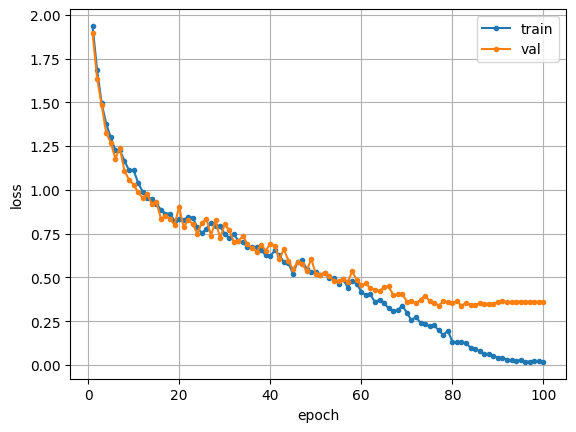

In [26]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['train loss']の長さまでの範囲）
xs = np.arange(1, len(history['train loss']) + 1)
# トレーニング損失をプロット
ax.plot(xs, history['train loss'], '.-', label='train')
# 検証損失をプロット
ax.plot(xs, history['val loss'], '.-', label='val')

ax.set_xlabel('epoch') # x軸のラベルを設定
ax.set_ylabel('loss') # y軸のラベルを設定
ax.legend() # 凡例を表示
ax.grid() # グリッドを表示
plt.show() # グラフを表示


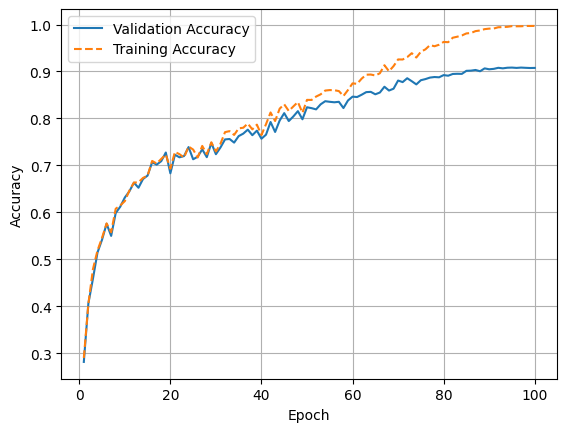

In [27]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['val acc']の長さまでの範囲）
xs = np.arange(1, len(history['val acc']) + 1)
# バリデーションデータの正解率をプロット
ax.plot(xs, history['val acc'], label='Validation Accuracy', linestyle='-')
# トレーニングデータの正解率をプロット
ax.plot(xs, history['train acc'], label='Training Accuracy', linestyle='--')

ax.set_xlabel('Epoch') # x軸のラベルを設定
ax.set_ylabel('Accuracy') # y軸のラベルを設定
ax.grid() # グリッドを表示
ax.legend()  # 凡例を追加
plt.show() # グラフを表示
